In [64]:
import seaborn as sns  # Seaborn for data visualization
import pandas as pd  # Pandas for data manipulation and analysis
import numpy as np  # NumPy for numerical computations
import matplotlib.pyplot as plt

# Imputation techniques from Scikit-learn
from sklearn.impute import KNNImputer  # KNN Imputer for filling missing values using K-Nearest Neighbors
from sklearn.ensemble import RandomForestRegressor  # Random Forest for machine learning-based imputation
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Linear regression model and data splitting tools from scikit-learn
from sklearn.linear_model import LinearRegression  # For building linear regression models
from sklearn.model_selection import train_test_split  # For splitting data into train/test sets
from scipy.stats import (
    ttest_1samp,     # One-sample T-test (compare sample mean to a hypothesized value)
    ttest_ind,       # Two-sample T-test (compare means of two independent samples)
    mannwhitneyu,    # Mann-Whitney U (non-parametric test for two independent groups)
    shapiro,         # Shapiro-Wilk test (checks if data is normally distributed)
    chisquare,       # Chi-square test (commonly for goodness-of-fit on categorical data)
    chi2_contingency # Chi-square test for independence (analyzes contingency tables)
)
# Regression model evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score 

 # Layers module for defining neural network architecture

# Label Encoding from Scikit-learn
from sklearn.preprocessing import LabelEncoder

# Read the dataset into a pandas dataframe
read_df = pd.read_csv('pwt1001.csv')
print(read_df.isnull().sum())

countrycode          0
country              0
currency_unit        0
year                 0
rgdpe             2411
rgdpo             2411
pop               2411
emp               3281
avh               9318
hc                4173
ccon              2411
cda               2411
cgdpe             2411
cgdpo             2415
cn                2496
ck                5720
ctfp              6403
cwtfp             6403
rgdpna            2411
rconna            2411
rdana             2411
rnna              2496
rkna              5720
rtfpna            6403
rwtfpna           6403
labsh             4840
irr               5270
delta             2496
xr                2411
pl_con            2411
pl_da             2411
pl_gdpo           2411
i_cig             2411
i_xm              2411
i_xr              2411
i_outlier         2411
i_irr             5270
cor_exp          11157
statcap          10693
csh_c             2411
csh_i             2411
csh_g             2411
csh_x             2411
csh_m      

The data set has many missing values and is too large to handle for this assignment. The solution was to make the range of years smaller and reduce the table to only have the needed columns.

In [86]:
#Get specific data from 2000-2018
df = read_df[(read_df["year"] >= 2000) & (read_df["year"] <= 2018)]
df_selected = df[["country", "year", "rgdpo", "pop"]].dropna()
# Check missing values
print(df_selected.isnull().sum())

country    0
year       0
rgdpo      0
pop        0
dtype: int64


In [87]:
# Display the first few rows of the dataframe to confirm the data has been loaded correctly
print(df_selected.head())

   country  year   rgdpo  pop
50   Aruba  2000  4130.0  0.0
51   Aruba  2001  4728.0  0.0
52   Aruba  2002  3555.0  0.0
53   Aruba  2003  3702.0  0.0
54   Aruba  2004  4228.0  0.0


In [106]:
# Calculate gross domestic product per capita
df_selected = df_selected[df_selected["pop"] > 0]  # Remove rows where population is zero
df_selected["gdp_per_capita"] = df_selected["rgdpo"] / df_selected["pop"] # Create new gdp column
print(df_selected[["gdp_per_capita"]].describe())

       gdp_per_capita
count     2987.000000
mean     17709.493130
std      20757.080828
min        376.275862
25%       3480.750000
50%       9860.428571
75%      25303.906699
max     232053.000000


From this we can deduce that: 
* The GDP per capita varies significantly, ranging from $376 to $232k.
* This has a right skewed distribution with a few countries having very high GDP per capita.
* There is high dispersion.


In [53]:
# Calculate mean, median, mode, and quantiles

# Overall economic performance and standard of living of a country or region
mean_gdp = df_selected["gdp_per_capita"].mean()
median_gdp = df_selected["gdp_per_capita"].median()
# The most common economic condition among countries (detect clusters later)
mode_gdp = df_selected["gdp_per_capita"].mode().values
# Divide the GDP per capita data into intervals (determine income levels later)
quantiles_gdp = df_selected["gdp_per_capita"].quantile([0.25, 0.5, 0.75])

# GDP statistics
print("\nDescriptive Statistics for GDP per Capita (2000-2018):")
print(f"Mean GDP per Capita: {mean_gdp}")
print(f"Median GDP per Capita: {median_gdp}")
print(f"Mode GDP per Capita: {mode_gdp}")
print("Quantiles of GDP per Capita:")
print(quantiles_gdp)



Descriptive Statistics for GDP per Capita (2000-2018):
Mean GDP per Capita: 17709.49312963972
Median GDP per Capita: 9860.42857142857
Mode GDP per Capita: [2213. 6102.]
Quantiles of GDP per Capita:
0.25     3480.750000
0.50     9860.428571
0.75    25303.906699
Name: gdp_per_capita, dtype: float64


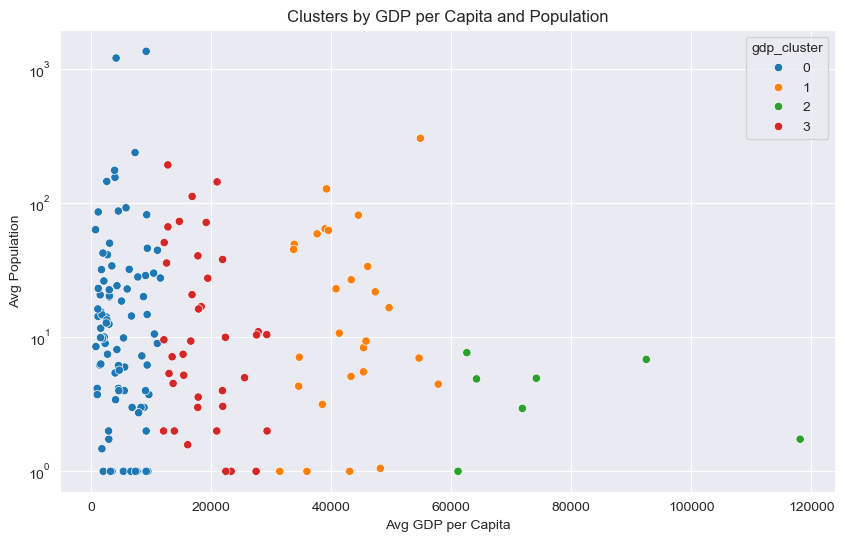


Cluster 0 (88 countries):
Venezuela (Bolivarian Republic of); Colombia; Azerbaijan; Tunisia; Iraq; Bosnia and Herzegovina; Maldives; Ukraine; Paraguay; Ecuador; Egypt; Montenegro; Namibia; China; Peru; Georgia; Eswatini; Albania; Sri Lanka; Jordan; Armenia; Mongolia; Uzbekistan; Fiji; Suriname; Indonesia; Jamaica; Guatemala; Guyana; Morocco; Angola; Philippines; El Salvador; Republic of Moldova; Bolivia (Plurinational State of); Bhutan; Syrian Arab Republic; Nicaragua; State of Palestine; Lao People's DR; Congo; Viet Nam; Ghana; Honduras; India; Mauritania; Kyrgyzstan; Nigeria; Pakistan; Cabo Verde; Sudan; Djibouti; Myanmar; Côte d'Ivoire; Cameroon; Yemen; Senegal; Gambia; Lesotho; Kenya; Tajikistan; Zambia; Bangladesh; Cambodia; Zimbabwe; Benin; Guinea; Nepal; Comoros; U.R. of Tanzania: Mainland; Haiti; Mali; Guinea-Bissau; Uganda; Burkina Faso; Togo; Chad; Rwanda; Madagascar; Sierra Leone; Mozambique; Ethiopia; Malawi; Niger; Liberia; Central African Republic; Burundi; D.R. of the C

In [90]:
# Group by country
df_avg_gdp = df_selected.groupby("country")["gdp_per_capita"].mean().reset_index()
df_avg_gdp.columns = ["country", "avg_gdp_per_capita"]

scaler = StandardScaler()
gdp_scaled = scaler.fit_transform(df_avg_gdp[["avg_gdp_per_capita"]])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=0)
df_avg_gdp["gdp_cluster"] = kmeans.fit_predict(gdp_scaled)
pop_avg = df_selected.groupby("country")["pop"].mean().reset_index()
df_plot = df_avg_gdp.merge(pop_avg, on="country")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x="avg_gdp_per_capita", y="pop", hue="gdp_cluster", palette="tab10")
plt.title("Clusters by GDP per Capita and Population")
plt.xlabel("Avg GDP per Capita")
plt.ylabel("Avg Population")
plt.yscale("log")  
plt.show()

# Group countries by cluster and list them
for cluster_id in sorted(df_avg_gdp["gdp_cluster"].unique()):
    countries_in_cluster = df_avg_gdp[df_avg_gdp["gdp_cluster"] == cluster_id].sort_values("avg_gdp_per_capita", ascending=False)
    
    print(f"\nCluster {cluster_id} ({len(countries_in_cluster)} countries):")
    print("; ".join(countries_in_cluster["country"].values))

* Cluster 2 contains outliers.
* Cluster 2 has relatively low population but high GDP.

In [75]:
# Check Data Distribution Using Shapiro-Wilk Test
def check_distribution(df_avg_gdp):
    distribution_results = {}
    numeric_cols = df_avg_gdp.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        col_data = df_avg_gdp[col].dropna()
        if len(col_data) > 2:  
            sample_size = min(len(col_data), 5000)
            sample = col_data.sample(n=sample_size, random_state=42)
            stat, p = shapiro(sample)
            distribution_results[col] = "Normal" if p > 0.05 else "Not Normal"
        else:
            distribution_results[col] = "Test Failed (too few data)"

    return distribution_results

distribution_results = check_distribution(df_avg_gdp)
print("Distribution Check:\n", distribution_results)

Distribution Check:
 {'avg_gdp_per_capita': 'Not Normal', 'gdp_cluster': 'Not Normal'}


In [76]:
# Split the data into two groups, (developing and developed countries)
df_with_clusters = df_selected.merge(df_avg_gdp[["country", "gdp_cluster"]], on="country")
#developing
groupA = df_with_clusters[df_with_clusters["gdp_cluster"] == 0]["gdp_per_capita"]
#developed
groupB = df_with_clusters[df_with_clusters["gdp_cluster"] == 1]["gdp_per_capita"]

u_stat, p_val_u = mannwhitneyu(groupA, groupB, alternative='two-sided')
print("Mann-Whitney U Test:")
print(f"U-statistic: {u_stat:.4f}")
print(f"P-value: {p_val_u:.6f}")

Mann-Whitney U Test:
U-statistic: 54.0000
P-value: 0.000000


* There is significant difference in GDP between the developed and developing countries.

Factors that could be affecting results:
* The population in developing countries is very high.
* Developing countries have lower production and manufacturing.
* There is poor management of resources(Governance) in developing countries.
* Developed countries are more industrialized.

In [49]:
# High mean = higher standard of living
countries = ["United States", "Germany", "Egypt", "India"]
df_filtered = df_selected[df_selected["country"].isin(countries)]
mean_gdp_by_country = df_filtered.groupby("country")["gdp_per_capita"].mean()

# examples
print("\nMean GDP per Capita by Country (2000-2018):")
print(mean_gdp_by_country)


Mean GDP per Capita by Country (2000-2018):
country
Egypt             9257.437132
Germany          44525.402015
India             4158.292134
United States    54865.084563
Name: gdp_per_capita, dtype: float64


In [62]:
#sort values to have top 10 countries on average
top_10_avg_gdp_per_capita = df_avg_gdp.sort_values(by="avg_gdp_per_capita", ascending=False).head(10)

# Display the result
print("Top performing countries over the years:")
print(top_10_avg_gdp_per_capita)

Top performing countries over the years:
                  country  avg_gdp_per_capita  gdp_cluster
117                 Qatar       118147.359649            2
150  United Arab Emirates        92509.161487            2
108                Norway        74182.536842            2
78                 Kuwait        71859.482456            2
127             Singapore        64219.769298            2
137           Switzerland        62605.226295            2
30       China, Macao SAR        61139.166667            2
70                Ireland        57841.960526            1
152         United States        54865.084563            1
29   China, Hong Kong SAR        54644.285714            1


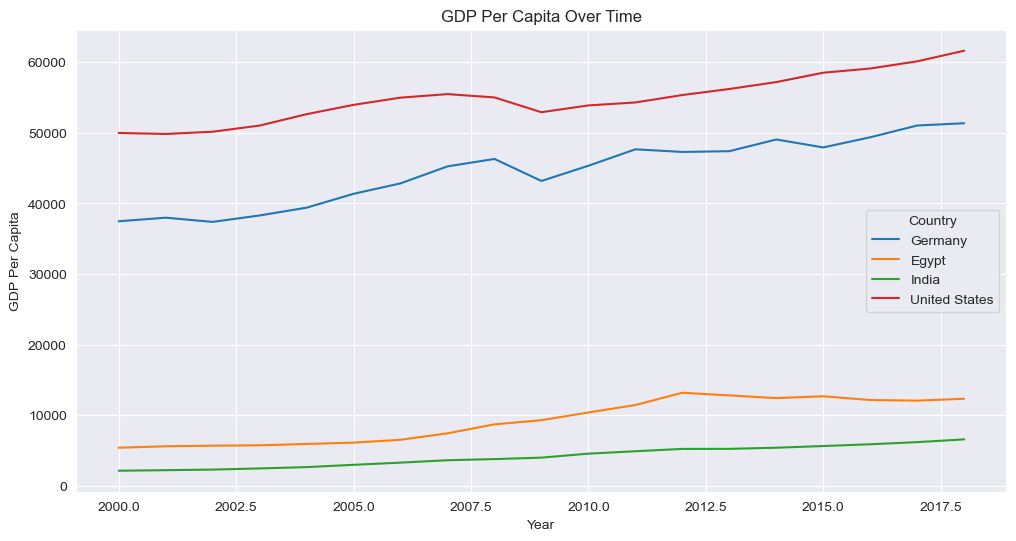

In [99]:
# visualising gdp per capita
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_filtered, x="year", y="gdp_per_capita", hue="country")
plt.title("GDP Per Capita Over Time")
plt.xlabel("Year")
plt.ylabel("GDP Per Capita")
plt.legend(title="Country")
plt.grid(True)
plt.show()


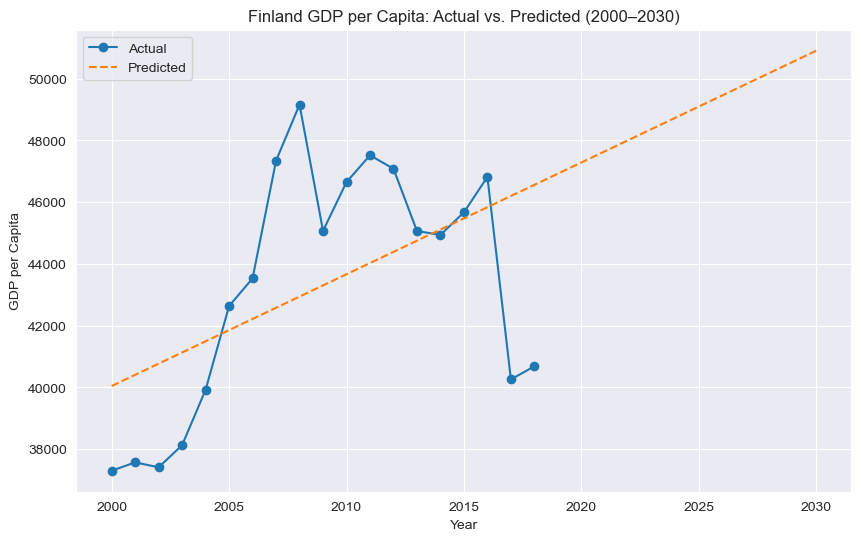

In [85]:
# Linear Regression with Scikit-Learn
# Choose a country to model
country = ("Finland")
df_country = df_selected[df_selected["country"] == country][["year", "gdp_per_capita"]]

# Train/Test split
X = df_country["year"].values.reshape(-1, 1)
y = df_country["gdp_per_capita"].values
model = LinearRegression()
model.fit(X, y)

# Predict for future years
future_years = np.arange(2000, 2031).reshape(-1, 1)
gdp_predictions = model.predict(future_years)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(df_country["year"], df_country["gdp_per_capita"], label="Actual", marker='o')
plt.plot(future_years, gdp_predictions, label="Predicted", linestyle='--')
plt.title(f"{country} GDP per Capita: Actual vs. Predicted (2000–2030)")
plt.xlabel("Year")
plt.ylabel("GDP per Capita")
plt.legend()
plt.grid(True)
plt.show()

year
2000         NaN
2001    0.024582
2002    0.026327
2003    0.040269
2004    0.071240
Name: delta, dtype: float64


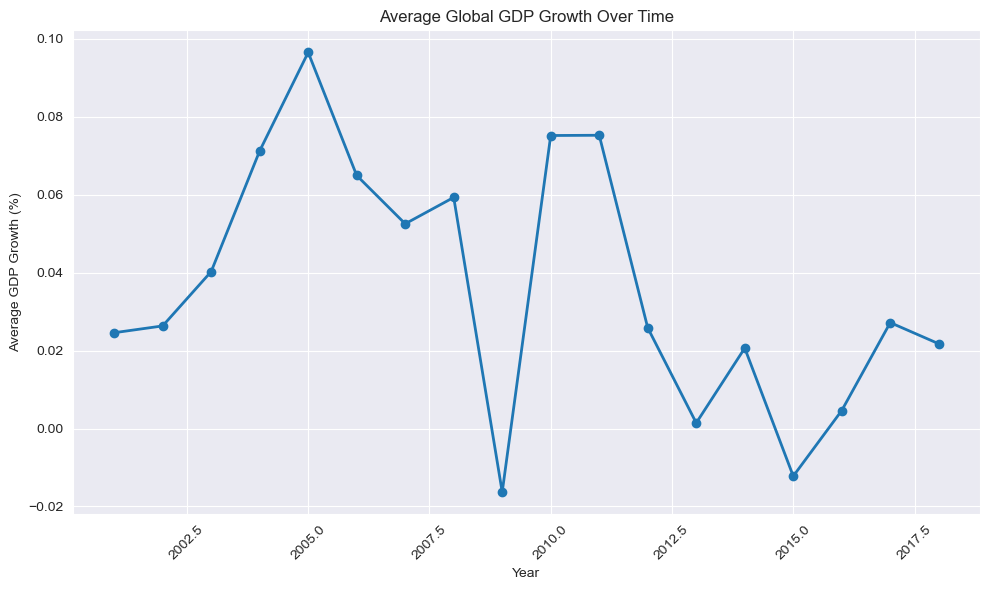

In [105]:
# Time-Based Analysis

# Right after loading or sub‑setting, force a copy:
df = df.copy()

# Ensure that the year column is numeric
df['year'] = df['year'].astype(int)

# Group by Year to see average GDP growth over time
# Sort for correct calculation
df = df.sort_values(["country", "year"])

# Calculate year-over-year fractional change
df["delta"] = df.groupby("country")["gdp_per_capita"].pct_change(fill_method=None)
# gdp_by_year = df.groupby('year')['GDP_growth'].mean()
gdp_by_year_frac = df.groupby('year')['delta'].mean()

# Iinspect the result
# print(gdp_by_year.head())
print(gdp_by_year_frac.head())

# Plot the average GDP growth by year
plt.figure(figsize=(10,6))
gdp_by_year_frac.plot(marker='o', linewidth=2)
plt.title('Average Global GDP Growth Over Time')
plt.xlabel('Year')
plt.ylabel('Average GDP Growth (%)')
plt.grid(True)

# rotate x‐labels if many years
plt.xticks(rotation=45)

# tighten layout so labels aren’t chopped off
plt.tight_layout()
plt.show()